# Genre Prediction
Test task for the Hi Karl interview. I use data about events to predict a music genre of the event.

In [493]:
%matplotlib inline
import json
import random
from collections import defaultdict
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import sklearn.preprocessing
import sklearn.cross_validation
import sklearn.tree
import sklearn.ensemble
import nltk
import gensim

I use pandas to have a look at data. After data is loaded from CSV I convert it into numpy array. It helps with creating fast, readable and extendable code.

In [84]:
DATA_FILE_PATH = 'NYCevents.csv'
df = pd.read_csv(DATA_FILE_PATH, sep=',')
events = df.values
df.head()

,_id,artists,cost,description,end,genre_categories,promoters,source,start,tags,ticket_status,title,url,venue,venue_address,venue_location_lat,venue_location_lng,venue_name,venue_aggregated
0,EB_24633274788,[],Check ticket supplier,Club Bonafide opens at 6:00pm | 21+ admitted |...,1.482979e+09,[],[],eventbrite,1.482971e+09,[],1.0,Rachel Therrien Latin Jazz Quartet at Club Bon...,https://www.eventbrite.com/e/rachel-therrien-l...,"{u'name': u'Club Bonafide', u'tags': [], u'ide...",212 East 52nd St,40.759394,-73.969780,Club Bonafide,"{u'name': u'Club Bonafide', u'tags': [], u'ide..."
1,EB_25870011902,[],Check ticket supplier,Master of the Hammond B-3 organ for more than ...,1.488076e+09,[u'house'],[],eventbrite,1.488071e+09,[],1.0,Dr. Lonnie Smith Trio,https://www.eventbrite.com/e/dr-lonnie-smith-t...,"{u'name': u'Kumble Theater', u'tags': [], u'id...",LIU Brooklyn Campus,40.690399,-73.981133,Kumble Theater,"{u'name': u'Kumble Theater', u'tags': [], u'id..."
2,EB_26234588360,[],Check ticket supplier,Club Bonafide opens at 6:00pm | 21+ admitted |...,1.483155e+09,[],[],eventbrite,1.483151e+09,[],1.0,Cookin' Hooks with Billy Ruegger - Late Night ...,https://www.eventbrite.com/e/cookin-hooks-with...,"{u'name': u'Club Bonafide', u'tags': [], u'ide...",212 East 52nd St,40.759394,-73.969780,Club Bonafide,"{u'name': u'Club Bonafide', u'tags': [], u'ide..."
3,EB_27029923228,[],Check ticket supplier,Doors at 10AMAdvance $20 | At the Door $25 ...,1.486228e+09,"[u'rock', u'pop']",[],eventbrite,1.486224e+09,[],1.0,Paper Canoe Co.,https://www.eventbrite.com/e/paper-canoe-co-ti...,"{u'name': u'National Sawdust', u'tags': [], u'...",80 North 6th Street,40.718902,-73.961340,National Sawdust,"{u'name': u'National Sawdust', u'tags': [], u'..."
4,EB_28370571142,[],Check ticket supplier,Popgun Presents\nChad Valley & Computer Magic\...,1.486098e+09,[u'indie pop'],[],eventbrite,1.486080e+09,[],1.0,PopGun Presents: Chad Valley & Computer Magic ...,https://www.eventbrite.com/e/popgun-presents-c...,"{u'name': u'Brooklyn Bazaar', u'tags': [], u'i...",150 Greenpoint Avenue,40.729924,-73.954635,Brooklyn Bazaar,"{u'name': u'Brooklyn Bazaar', u'tags': [], u'i..."


In [172]:
df.count()

_id                   12697
artists               12687
cost                  11585
description            8283
end                    8020
genre_categories      12697
promoters              8020
source                12687
start                  8020
tags                   8020
ticket_status          6837
title                 12687
url                    8020
venue                  5874
venue_address         11851
venue_location_lat    11841
venue_location_lng    11841
venue_name            12687
venue_aggregated       8020
dtype: int64

Some elements doesn't have id. To ensure correct a model's work in the future let's fill them.

In [86]:
def fill_id(elem):
    # If id isn't provided, choose random value
    if elem is np.NaN: 
        return 'RANDOM{}'.format(random.randint(1, 10 ** 15))
    return elem
df['_id'] = df['_id'].apply(fill_id)

Let's understand which tags should be predicted by model.

In [87]:
all_categories = set()


def find_all_categories(elem):
    global all_categories
    current_categories = set(eval(elem))
    all_categories = all_categories.union(current_categories)

In [88]:
df.genre_categories.apply(find_all_categories)
all_categories = list(all_categories)

In [89]:
print('Categories num:', len(all_categories))

Categories num: 16


And get other information about dataset

In [90]:
print('NaN counts:')
for column_name in list(df):
    print(column_name, '-', df[column_name].isnull().sum())

NaN counts:
_id - 0
artists - 10
cost - 1112
description - 4414
end - 4677
genre_categories - 0
promoters - 4677
source - 10
start - 4677
tags - 4677
ticket_status - 5860
title - 10
url - 4677
venue - 6823
venue_address - 846
venue_location_lat - 856
venue_location_lng - 856
venue_name - 10
venue_aggregated - 4677


In [91]:
print('Types:')
for column_name in list(df):
    print(column_name, '-', df[column_name].dtype)

Types:
_id - object
artists - object
cost - object
description - object
end - float64
genre_categories - object
promoters - object
source - object
start - float64
tags - object
ticket_status - float64
title - object
url - object
venue - object
venue_address - object
venue_location_lat - float64
venue_location_lng - float64
venue_name - object
venue_aggregated - object


## Feature generation

In [92]:
(ID_COLUMN, ARTISTS_COLUMN, COST_COLUMN, 
 DESCRIPTION_COLUMN, END_COLUMN, GENRE_CATEGORIES_COLUMN,
 PROMOTERS_COLUMN, SOURCE_COLUMN, START_COLUMN, TAGS_COLUMN,
 TICKET_STATUS_COLUMN, TITLE_COLUMN, URL_COLUMN, VENUE_COLUMN,
 VENUE_ADRESS_COLUMN, VENUE_LOCATION_LAT_COLUMN,
 VENUE_LOCATION_LNG_COLUMN, VENUE_NAME_COLUMN, VENUE_AGGREGATED_COLUMN) = range(19)

### Ticket status

In [93]:
df.ticket_status.value_counts()

1.0    6494
3.0     179
2.0     164
Name: ticket_status, dtype: int64

Trying to use conception that **non existence of the value may be a feature**.
Actually, this decision should depend on the way data is collected.

In [164]:
def ticket_status_feature(elem):
    if np.isnan(elem[TICKET_STATUS_COLUMN]):
        yield 0.0 # Generator is used to support multiple features by one function
    else:
        yield elem[TICKET_STATUS_COLUMN]

### Artists

In [216]:
# Find all names of artists
artist_names = []
for elem in events:
    # Pass all NaNs
    if type(elem[ARTISTS_COLUMN]) == float:
        continue
    elem_artists = eval(elem[ARTISTS_COLUMN])
    for artist in elem_artists:
        if 'name' in artist:
            artist_names.append(artist['name'])
artist_names = list(set(artist_names))

In [232]:
artist_names_mlb = sklearn.preprocessing.MultiLabelBinarizer()
artist_names_mlb.fit([artist_names])

MultiLabelBinarizer(classes=None, sparse_output=False)

In [207]:
all_genres = []
for elem in events:
    # Pass all NaNs
    if type(elem[ARTISTS_COLUMN]) == float:
        continue
    elem_artists = eval(elem[ARTISTS_COLUMN])
    for artist in elem_artists:
        if 'genres' in artist:
            all_genres.extend(artist['genres'])
all_genres = list(set(all_genres))

In [235]:
all_genres_mlb = sklearn.preprocessing.MultiLabelBinarizer()
all_genres_mlb.fit([all_genres])

MultiLabelBinarizer(classes=None, sparse_output=False)

In [249]:
def artist_feature(elem):
    elem_artist_names = []
    elem_genres = []
    if type(elem[ARTISTS_COLUMN]) != float:
        for artist in eval(elem[ARTISTS_COLUMN]):
            # Due to high execution time I deleted artist names feature
            # if 'name' in artist:
            #     elem_artist_names.append(artist['name'])
            if 'genres' in artist:
                elem_genres.extend(artist['genres'])
    yield all_genres_mlb.transform([elem_genres])[0]

### Cost

In [262]:
different_costs = []
for elem in events:
    different_costs.append(str(elem[COST_COLUMN]))
different_costs = list(set(different_costs))

In [263]:
cost_lb = sklearn.preprocessing.LabelBinarizer()
cost_lb.fit(different_costs)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [264]:
def cost_feature(elem):
    yield cost_lb.transform([str(elem[COST_COLUMN])])[0]

### Description

In [336]:
stemmer = nltk.stem.snowball.SnowballStemmer('english')


def prepare_description(text):
    stoplist = set('for a of the and to in at | www http https com'.split())
    words = []
    for word in text.lower().split():
        if word not in stoplist:
            words.append(stemmer.stem(word))
    return words

In [337]:
documents = []
for elem in events:
    desc = elem[DESCRIPTION_COLUMN]
    if type(desc) == float:
        continue
    try:
        documents.append(' '.join(json.loads(desc)))
    except json.JSONDecodeError:
        documents.append(desc)

In [338]:
texts = [prepare_description(document)
         for document in tqdm.tqdm(documents)]
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1
texts = [[token for token in text if frequency[token] > 1]
         for text in texts]

100%|██████████| 8283/8283 [00:11<00:00, 747.43it/s] 


In [339]:
dictionary = gensim.corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
# tfidf = gensim.models.TfidfModel(corpus)

In [579]:
lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=20)

In [581]:
lda.show_topics(num_topics=5, num_words=5)

[(17,
  '0.013*"v" + 0.011*"women" + 0.007*"youtub" + 0.007*"ymusic" + 0.007*"door"'),
 (9,
  '0.030*"blue" + 0.017*"band" + 0.013*"new" + 0.011*"york" + 0.010*"featur"'),
 (1,
  '0.017*"music" + 0.017*"jazz" + 0.014*"latin" + 0.013*"perform" + 0.012*"new"'),
 (5,
  '0.023*"ticket" + 0.022*"30pm" + 0.019*"will" + 0.018*"door" + 0.016*"00pm"'),
 (7,
  '0.018*"music" + 0.010*"new" + 0.009*"record" + 0.008*"perform" + 0.007*"album"')]

In [382]:
def description_feature(elem):
    if type(elem[DESCRIPTION_COLUMN]) is float:
        yield np.zeros(20)
        return
    text = elem[DESCRIPTION_COLUMN]
    try:
        desc = ' '.join(json.loads(text))
    except json.JSONDecodeError:
        desc = text
    desc = prepare_description(desc)
    desc = [token for token in desc if frequency[token] > 1]
    bow = dictionary.doc2bow(desc)
    topics = lda.get_document_topics(bow, minimum_probability=0)
    vec = [topic[1] for topic in topics]
    yield np.asarray(vec)

### Aggregate all features

In [383]:
feature_generators = [ticket_status_feature, artist_feature, cost_feature, description_feature]

In [393]:
events_features = None
current_index = 0
genre_groups = defaultdict(set)
for elem in tqdm.tqdm(events):
    elem_features = np.empty((0), dtype='float64')
    for generator in feature_generators:
        for feature in generator(elem):
            if type(feature) in [float, int]:
                elem_features = np.concatenate([elem_features, np.asarray([feature], dtype='float64')])
            else:
                elem_features = np.concatenate([elem_features, feature])
    if events_features is None:
        events_features = elem_features
        events_features.resize((1, elem_features.shape[0]))
    else:
        elem_features.resize((1, elem_features.shape[0]))
        events_features = np.concatenate([events_features, elem_features])
    genre_categories = eval(elem[GENRE_CATEGORIES_COLUMN])
    for category in genre_categories:
        genre_groups[category].add(current_index)
    current_index += 1

100%|██████████| 12697/12697 [03:27<00:00, 61.17it/s]


In [365]:
events_features.shape

(1, 1860)

## Making model

### Single class classifier

In [424]:
# Find true examples
X = None
for event_index in genre_groups['rock']:
    event = events_features[event_index]
    if X is None:
        X = np.resize(event, (1, event.shape[0]))
    else:
        X = np.concatenate(
            [X,
             np.resize(event, (1, event.shape[0]))]
        )
Y = np.ones(X.shape[0])

In [427]:
# And false examples
true_samples_num = len(X)
false_genres = set(genre_groups.keys())
false_genres.remove('rock')
for genre in false_genres:
    # Balance training set
    for event_index in list(genre_groups[genre])[:int(true_samples_num / len(false_genres))]:
        if event_index in genre_groups['rock']:
            continue
        event = events_features[event_index]
        X = np.concatenate(
            [X,
             np.resize(event, (1, event.shape[0]))]
        )
        Y = np.concatenate(
            [Y, [0]]
        )

In [446]:
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X, Y, random_state=42)

In [547]:
# Support vector machine
clf = sklearn.svm.LinearSVC()

# Random forest
# clf = sklearn.tree.RandomForestClassifier()

# SGD
# clf = sklearn.linear_model.SGDClassifier()

clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [530]:
clf.get_params()

{'C': 0.5,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [548]:
print('Accuracy score', sklearn.metrics.accuracy_score(clf.predict(X_test), y_test))
print('F1 score', sklearn.metrics.f1_score(clf.predict(X_test), y_test))

Accuracy score 0.83064516129
F1 score 0.886486486486


In [549]:
y_score = clf.decision_function(X_test)
#y_score = clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_score)
roc_auc = sklearn.metrics.auc(fpr, tpr)
print('ROC AUC score', roc_auc)

ROC AUC score 0.841179197182


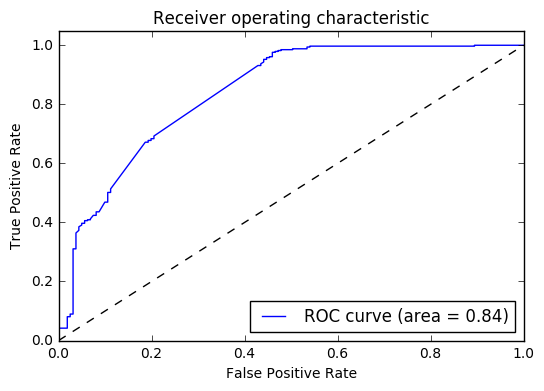

In [533]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Creating classifier for all genres

In [551]:
event_genre_mlb = sklearn.preprocessing.MultiLabelBinarizer()
event_genre_mlb.fit([list(genre_groups.keys())])

MultiLabelBinarizer(classes=None, sparse_output=False)

In [571]:
X, Y = None, None
current_index = 0
for event in tqdm.tqdm(events_features):
    genre_categories = eval(events[current_index][GENRE_CATEGORIES_COLUMN])
    y_vec = event_genre_mlb.transform([genre_categories])
    if X is None:
        X = np.resize(event, (1, event.shape[0]))
    else:
        X = np.concatenate(
            [X,
             np.resize(event, (1, event.shape[0]))]
        )
    if Y is None:
        Y = np.resize(y_vec, (1, y_vec.shape[1]))
    else:
        Y = np.concatenate(
            [Y,
             np.resize(y_vec, (1, y_vec.shape[1]))]
        )
    current_index += 1

100%|██████████| 12697/12697 [02:46<00:00, 76.21it/s]


In [572]:
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X, Y, random_state=42)

In [573]:
clf = sklearn.multiclass.OneVsRestClassifier(sklearn.svm.LinearSVC())
clf.fit(X_train, y_train)
y_score = clf.decision_function(X_test)

0.941078938855
0.968278041074
nan
nan
0.921331014959
nan
0.918318806652
0.832750397456
0.940216602305
0.833078419099
0.977025316456
0.942112852782
nan
0.891906244844
0.681234879562
0.952729971316


/home/sheldonai/anaconda3/lib/python3.5/site-packages/sklearn/metrics/ranking.py:538: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/sheldonai/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


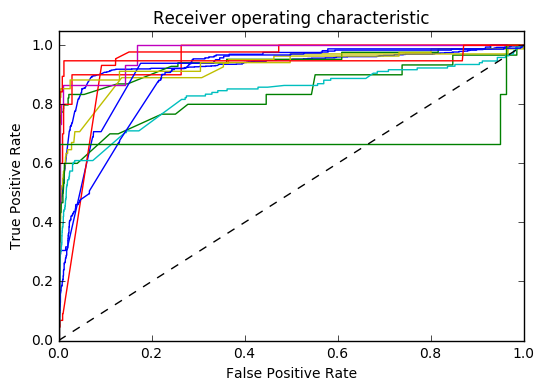

In [584]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(genre_groups.keys())):
    fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = sklearn.metrics.roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = sklearn.metrics.auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"])
for i in range(len(genre_groups.keys())):
    plt.plot(fpr[i], tpr[i])
    print(roc_auc[i])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()